# Modern Portfolio Theory

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

In [363]:
from scipy.optimize import minimize
from numba import jit

## Example, 2 companies shares

## Intro

In [4]:
tickers_list = ['JPM','AAPL']
tickers_list=sorted(tickers_list)
tickers_list

['AAPL', 'JPM']

In [5]:
# Get the data for the stock AAPL
data = yf.download(tickers_list,'2018-05-20',today)

[*********************100%***********************]  2 of 2 completed


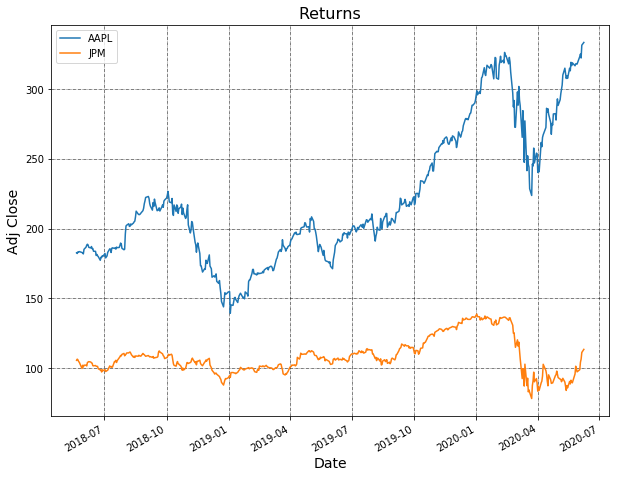

In [6]:
(data['Adj Close']).plot(figsize=(10,8),linestyle='-')
plt.title('Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close',fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

We only need montly Adj Close.

In [7]:
d=yf.download(tickers_list,'2018-01-01',today,interval='1mo')

[*********************100%***********************]  2 of 2 completed


In [8]:
mdata=d['Adj Close'].dropna()

In [9]:
mreturn=mdata.pct_change()

The next columns are the 'annual increase' in percentages for the different months.

In [10]:
yr_return=mreturn.multiply(365/mdata.index.to_series().diff().dt.days, axis="index")

In [11]:
yr_mean=yr_return.mean()
yr_mean

AAPL    0.337608
JPM     0.048602
dtype: float64

In [12]:
yr_mean.values

array([0.33760784, 0.04860244])

In [13]:
yr_var=yr_return.var()
yr_var

AAPL    1.165202
JPM     0.935048
dtype: float64

Here we clearly see that a high average return gives a high variance (more risk).

### Covariant Matrix

In [14]:
covar=yr_return.cov()
covar

,AAPL,JPM
AAPL,1.165202,0.558433
JPM,0.558433,0.935048


In [15]:
np_covar=covar.values

### Expected return and variance

In [24]:
def exp_return(alpha):
    return alpha @ np.transpose(yr_mean.values)

In [25]:
def variance(alpha):
    term1=0
    term2=0
    for i in range(len(alpha)):        
        for j in range(len(alpha)):
            if i!=j:
                term2+=alpha[i]*alpha[j]*np_covar[i,j]
            else:
                term1+=(alpha[i]**2)*np_covar[i,i]
    return term1+term2

### Plot with different weights

In [26]:
w=np.array([0,0])
for i in range(101):
    x=np.array([i, 100-i])
    w=np.vstack((w,x))


w=w[1:,:]/100

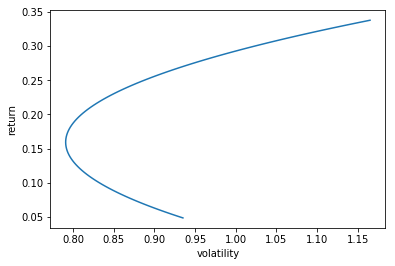

In [27]:
R=[]
V=[]
for i in w:
    R=np.append(R,exp_return(i))
    V=np.append(V,variance(i))
    
plt.plot(V,R)
plt.xlabel('volatility')
plt.ylabel('return')
plt.show()  

All the point on the graphs represent different compositions of the weights which equal to 1. As an investor we don't want to lose money so if we have to invest in these two stocks we chose the most left point on this graph, the point with mimimum variance which translates into risk. If the investor is a bit more 'ballsy' he can pick point on the graph more on the right. Then it becomes obvious that he has to chose a point that is in 'the upper halve' because that gives a higher return for the same amount of risk. Now we create an algorithm that finds the minumum of risk for the 2 stocks.

In [28]:
def constraint(alpha):
    s=sum(alpha)
    return 1-s

cons=[{'type': 'eq','fun': constraint}]

In [33]:
weight0=[1,1]

In [34]:
sol=minimize(variance, weight0, constraints=cons)
sol

     fun: 0.7908125665205938
     jac: array([1.58162515, 1.58162515])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.38297861, 0.61702139])

In [35]:
np.size(yr_mean.values)

2

In [36]:
expected_return=(sol.x)@(np.transpose(yr_mean.values))
expected_return

0.15928532488451358

In [40]:
print('Weights distribution with least amount of risk')
print(tickers_list)
print(sol.x)
print('')
print( 'Expected return:' , round(expected_return,3)*100, '%' )
print('Variance:' , round(sol.fun,3), '%')

Weights distribution with least amount of risk
['AAPL', 'JPM']
[0.38297861 0.61702139]

Expected return: 15.9 %
Variance: 0.791 %


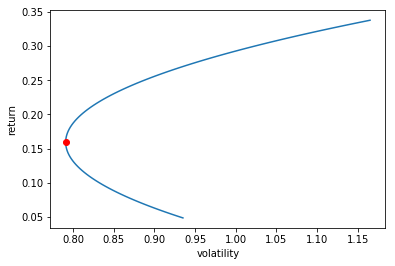

In [43]:
plt.plot(V,R)
plt.plot(sol.fun,expected_return,'ro')
plt.xlabel('volatility')
plt.ylabel('return')
plt.show() 

# More shares

Principle is totally the same and now we will focus on just the minimum risk point, that is what we try to achieve and is the whole point of risk minimisation.

In [256]:
tickers_list = ['JPM','AAPL','TSLA']
tickers_list=sorted(tickers_list)
tickers_list

['AAPL', 'JPM', 'TSLA']

In [321]:
n=len(tickers_list)

[*********************100%***********************]  3 of 3 completed


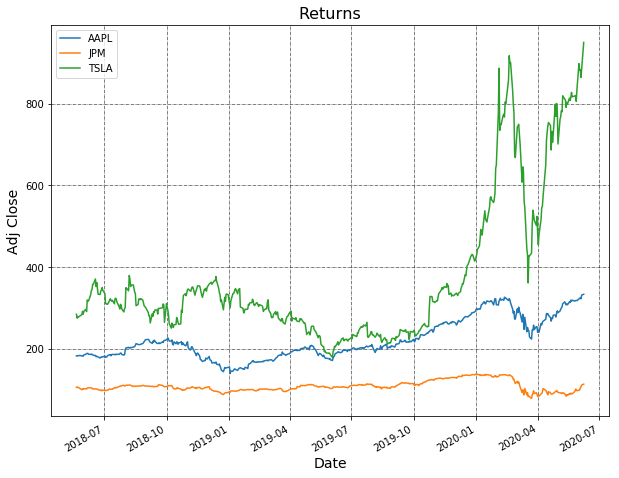

In [322]:
# Get the data for the stock AAPL
data = yf.download(tickers_list,'2018-05-20',today)
(data['Adj Close']).plot(figsize=(10,8),linestyle='-')
plt.title('Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close',fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

In [323]:
d=yf.download(tickers_list,'2018-01-01',today,interval='1mo')
mdata=d['Adj Close'].dropna()

[*********************100%***********************]  3 of 3 completed


In [324]:
mreturn=mdata.pct_change()
yr_return=mreturn.multiply(365/mdata.index.to_series().diff().dt.days, axis="index")
mo_var=yr_return.var()

In [325]:
yr_mean=yr_return.mean()
yr_mean

AAPL    0.349249
JPM     0.050278
TSLA    0.590342
dtype: float64

In [326]:
yr_var=yr_return.var()
yr_var

AAPL    1.202605
JPM     0.968355
TSLA    5.595781
dtype: float64

### Covariance Matrix

In [327]:
covar=yr_return.cov()
covar

,AAPL,JPM,TSLA
AAPL,1.202605,0.577771,0.985004
JPM,0.577771,0.968355,0.627355
TSLA,0.985004,0.627355,5.595781


In [328]:
np_covar=covar.values

In [273]:
def exp_return(alpha):
    return alpha @ np.transpose(yr_mean.values)

In [288]:
def variance(alpha):
    term1=0
    term2=0
    for i in range(len(alpha)):        
        for j in range(len(alpha)):
            if i!=j:
                term2+=alpha[i]*alpha[j]*np_covar[i,j]
            else:
                term1+=(alpha[i]**2)*np_covar[i,i]
    return term1+term2

In [347]:
def constraint(alpha):
    s=sum(alpha)
    return 1-s

con1=[{'type': 'eq','fun': constraint}]

In [331]:
def boundairies(N):
    lijst=[]
    b=(0,1)
    return [b for x in range(N)]

In [332]:
def alpha0(N):
    return np.array([1/N for x in range(N)])

In [341]:
weight0=alpha0(n)

In [315]:
bnds=boundairies(3)#[[0, 1], (0, 1), (0, 1)]

In [348]:
sol=minimize(variance, weight0, constraints=con1,bounds=boundairies(n))
sol

     fun: 0.8175210448756989
     jac: array([1.63483964, 1.63510619, 1.63834868])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.37641348, 0.61242337, 0.01116315])

In [336]:
sum(sol.x)

1.0

In [337]:
expected_return=(sol.x)@(np.transpose(yr_mean.values))
expected_return

0.1688439500385671

In [338]:
min_var= sol.fun
min_var

0.8175210448756989

In [339]:
print('Weights distribution with least amount of risk')
print(tickers_list)
print(sol.x)
print('')
print( 'Expected return:' , round(expected_return,3)*100, '%' )
print('Variance:' , round(min_var,3), '%')

Weights distribution with least amount of risk
['AAPL', 'JPM', 'TSLA']
[0.37641348 0.61242337 0.01116315]

Expected return: 16.900000000000002 %
Variance: 0.818 %


## Make plot

We want to see if this is indeed the minimum, therefore we put in some random numbers with the constraint that the weight is equal to 1.

In [343]:
import random

def generate(w):
    array=np.arange(len(w))
    for i in array:
        array[i]=random.randint(0,100)
    array=array/sum(array)
    return array

In [344]:
N=1000
w=np.zeros(len(weight0))
for i in range(N):
    x=generate(weight0)
    w=np.vstack((w,x))


w=w[1:,:]

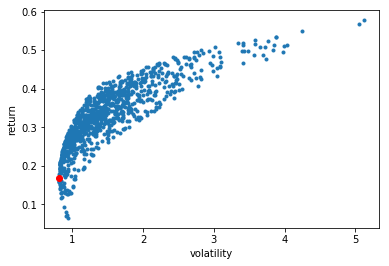

In [345]:
R=[]
V=[]
for i in w:
    R=np.append(R,exp_return(i))
    V=np.append(V,variance(i))
    
plt.plot(V,R,'.')
# plt.plot(0.2,exp_return(s.x),'ro')
plt.plot(min_var, expected_return,'ro')
plt.xlabel('volatility')
plt.ylabel('return')
plt.show()  

Here we clearly see that our calculated point is the point with minimum risk but also the effect of the effective frontier. For all points that are not on the border we can find a point that has the same amount of risk but with a higher return. Points not on the border are to be be avoided!!

To create this border we can do a similar algorithm but instead of finding the minimum risk. We can find the maximum return for a given amount of risk and find this optimal weight distribution.

In [349]:
def exp_return2(alpha):
    return -(alpha @ np.transpose(yr_mean.values))

In [350]:
def constraint1(alpha):
    s=sum(alpha)
    return s-1

cons1={'type': 'eq','fun': constraint1}

In [352]:
def constraint2(alpha):
    return variance(alpha)-2

cons2={'type': 'eq','fun': constraint2}
cons=[cons1, cons2]

In [354]:
s=minimize(exp_return2, weight0, constraints=cons, bounds=boundairies(3))

s

     fun: -0.4586915389077724
     jac: array([-0.34924949, -0.05027838, -0.59034209])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.54605802, 0.        , 0.45394198])

In [355]:
sum(s.x)

1.0

In [356]:
exp_return(s.x)

0.4586915389077724

In [360]:
v=np.linspace(min_var,min_var+4,100)

In [367]:
vector_r=np.zeros(len(v))
vector_v=np.zeros(len(v))

for i in range(len(vector_v)):
    def constraint2(alpha):
        return variance(alpha)-v[i]

    cons2={'type': 'eq','fun': constraint2}
    cons=[cons1, cons2, cons3]

    s=minimize(exp_return2, weight0, constraints=cons)
    
    vector_r[i]=-s.fun
    vector_v[i]=variance(s.x)

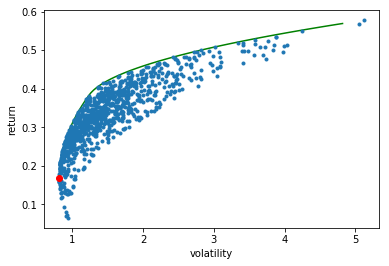

In [362]:
plt.plot(vector_v,vector_r,'g')
plt.plot(V,R,'.')

plt.plot(min_var, expected_return,'ro')
plt.xlim()
plt.xlabel('volatility')
plt.ylabel('return')
plt.show()  

Tadaa, this is the effective frontier. One should only take portfolio's that match those on the green line.